# M5 Forecasting - Accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn import preprocessing
from keras import Sequential, optimizers, regularizers
from keras.layers import GRU, LSTM, Dense
from keras.layers.core import Dropout, Flatten
import copy
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
calenderData = pd.read_csv('calendar.csv')
sell_pricesData = pd.read_csv('sell_prices.csv')
sales_trainData = pd.read_csv('sales_train_validation.csv')

#Unpivoting Sales Train Data
sales_trainData = sales_trainData.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                          var_name='d', value_name='dValue')

labelencoder = preprocessing.LabelEncoder()

calenderData = calenderData.fillna('No Event')
calenderData = calenderData.drop(columns = ['weekday'], axis = 1)
calenderData['d_scaled'] = copy.deepcopy(calenderData['d'].str.slice(start = 2))

calenderData

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,d_scaled
0,2011-01-29,11101,1,1,2011,d_1,No Event,No Event,No Event,No Event,0,0,0,1
1,2011-01-30,11101,2,1,2011,d_2,No Event,No Event,No Event,No Event,0,0,0,2
2,2011-01-31,11101,3,1,2011,d_3,No Event,No Event,No Event,No Event,0,0,0,3
3,2011-02-01,11101,4,2,2011,d_4,No Event,No Event,No Event,No Event,1,1,0,4
4,2011-02-02,11101,5,2,2011,d_5,No Event,No Event,No Event,No Event,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,5,6,2016,d_1965,No Event,No Event,No Event,No Event,0,1,1,1965
1965,2016-06-16,11620,6,6,2016,d_1966,No Event,No Event,No Event,No Event,0,0,0,1966
1966,2016-06-17,11620,7,6,2016,d_1967,No Event,No Event,No Event,No Event,0,0,0,1967
1967,2016-06-18,11621,1,6,2016,d_1968,No Event,No Event,No Event,No Event,0,0,0,1968


Event days =  36
No Event days =  1933


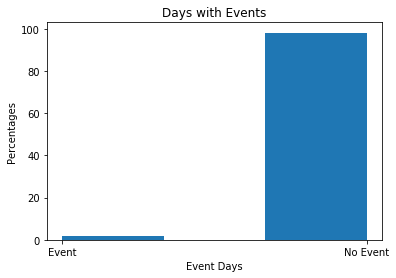

2139

In [3]:
print('Event days = ', len(calenderData.event_name_1.unique()) + len(calenderData.event_name_2.unique()))
print('No Event days = ', calenderData.shape[0] - len(calenderData.event_name_1.unique()) -
      len(calenderData.event_name_2.unique()))

event_col = []
for i in range(len(calenderData.event_name_1.unique()) + len(calenderData.event_name_2.unique())):
    event_col.append('Event')
for i in range(calenderData.shape[0] - len(calenderData.event_name_1.unique()) - len(calenderData.event_name_2.unique())):
    event_col.append('No Event')

plt.hist(event_col, weights = np.ones(len(event_col)) / len(event_col) * 100, bins = 3)
plt.title('Days with Events')
plt.xlabel('Event Days')
plt.ylabel('Percentages')
plt.show()

del event_col
gc.collect()

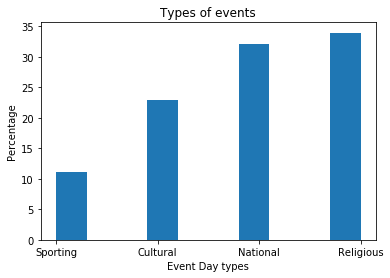

In [4]:
plt.hist(calenderData[~calenderData.event_type_1.isin(['No Event'])].event_type_1, 
         weights = np.ones(len(calenderData[~calenderData.event_type_1.isin(['No Event'])].event_type_1)) / 
         len(calenderData[~calenderData.event_type_1.isin(['No Event'])].event_type_1) * 100)
plt.title('Types of events')
plt.xlabel('Event Day types')
plt.ylabel('Percentage')
plt.show()

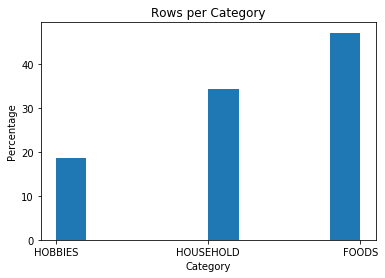

In [5]:
plt.hist(sales_trainData.cat_id, weights = np.ones(len(sales_trainData.cat_id)) / len(sales_trainData.cat_id) * 100)
plt.title('Rows per Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

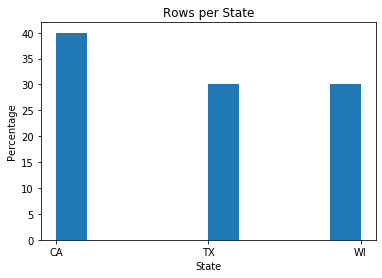

In [6]:
plt.hist(sales_trainData.state_id, weights = np.ones(len(sales_trainData.state_id)) / len(sales_trainData.state_id) * 100)
plt.title('Rows per State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.show()

In [7]:
calenderData['event_name_1'] = labelencoder.fit_transform(calenderData['event_name_1']) 
calenderData['event_type_1'] = labelencoder.fit_transform(calenderData['event_type_1'])
calenderData['event_name_2'] = labelencoder.fit_transform(calenderData['event_name_2'])
calenderData['event_type_2'] = labelencoder.fit_transform(calenderData['event_type_2'])
# calenderData['d_scaled'] = labelencoder.fit_transform(calenderData['d'])
calenderData = calenderData.astype({'wm_yr_wk': 'int16', 'wday': 'int16', 'month': 'int16', 'year': 'int16', 
                                    'event_name_1': 'int16', 'event_type_1': 'int16', 'event_name_2': 'int16', 
                                    'event_type_2': 'int16', 'snap_CA': 'int16', 'snap_TX': 'int16', 'snap_WI': 'int16',
                                    'd_scaled': 'int16'})

sell_pricesData = sell_pricesData.astype({'wm_yr_wk': 'int16'})

sales_trainData['dept_id'] = labelencoder.fit_transform(sales_trainData['dept_id'])
sales_trainData['cat_id'] = labelencoder.fit_transform(sales_trainData['cat_id'])
sales_trainData['state_id'] = labelencoder.fit_transform(sales_trainData['state_id'])
sales_trainData = sales_trainData.astype({'dept_id': 'int16', 'cat_id': 'int16', 'state_id': 'int16', 'dValue': 'int16'})

x_train = pd.merge(sell_pricesData, calenderData, how = 'inner', on = 'wm_yr_wk')

del sell_pricesData
gc.collect()
del calenderData
gc.collect()

x_train = pd.merge(sales_trainData, x_train, how = 'inner', on = ['store_id', 'item_id', 'd'])

x_train['item_id'] = labelencoder.fit_transform(x_train['item_id'])
x_train['store_id'] = labelencoder.fit_transform(x_train['store_id'])

x_train['d'] = copy.deepcopy(x_train['d_scaled'])
x_train = x_train.drop(columns = ['wm_yr_wk', 'd_scaled'], axis = 1)

x_train = x_train.astype({'item_id': 'int16', 'store_id': 'int16', 'd': 'int16'})

del sales_trainData
gc.collect()

x_train = x_train.fillna(0)
rowID_train = x_train['id']
y_train = x_train['dValue']
x_train = x_train.drop(columns = ['id', 'dValue'], axis = 1)

scaler = preprocessing.StandardScaler()

scale_x = x_train[['sell_price', 'year', 'snap_CA', 'snap_TX', 'snap_WI']]
scale_x = scaler.fit_transform(scale_x)
x_train = x_train.drop(columns = ['sell_price', 'year', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1)

x_train['sell_price'] = scale_x[:, 0]
x_train['year'] = scale_x[:, 1]
x_train['snap_CA'] = scale_x[:, 2]
x_train['snap_TX'] = scale_x[:, 3]
x_train['snap_WI'] = scale_x[:, 4]

del scale_x
gc.collect()

x_train

,item_id,dept_id,cat_id,store_id,state_id,d,date,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,year,snap_CA,snap_TX,snap_WI
0,1444,3,1,0,0,1,2011-01-29,1,1,19,2,3,1,-1.159955,-1.735328,-0.699221,-0.699896,-0.699958
1,1445,3,1,0,0,1,2011-01-29,1,1,19,2,3,1,-0.836773,-1.735328,-0.699221,-0.699896,-0.699958
2,1446,3,1,0,0,1,2011-01-29,1,1,19,2,3,1,-0.363753,-1.735328,-0.699221,-0.699896,-0.699958
3,1448,3,1,0,0,1,2011-01-29,1,1,19,2,3,1,0.461830,-1.735328,-0.699221,-0.699896,-0.699958
4,1451,3,1,0,0,1,2011-01-29,1,1,19,2,3,1,-1.089443,-1.735328,-0.699221,-0.699896,-0.699958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,1432,2,0,9,2,1913,2016-04-24,2,4,19,2,3,1,-0.419575,1.664101,-0.699221,-0.699896,-0.699958
46027953,1433,2,0,9,2,1913,2016-04-24,2,4,19,2,3,1,-0.566476,1.664101,-0.699221,-0.699896,-0.699958
46027954,1434,2,0,9,2,1913,2016-04-24,2,4,19,2,3,1,-0.125773,1.664101,-0.699221,-0.699896,-0.699958
46027955,1435,2,0,9,2,1913,2016-04-24,2,4,19,2,3,1,-0.919038,1.664101,-0.699221,-0.699896,-0.699958


In [8]:
total_x = copy.deepcopy(x_train[['date', 'd', 'sell_price', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
                                'year', 'wday', 'month']])
total_x['dValue'] = copy.deepcopy(y_train)

In [9]:
total_x = total_x.groupby(['date', 'd'], as_index=False, observed=True).mean()
total_x['date'] = pd.DatetimeIndex(total_x['date'])
total_x

,date,d,sell_price,event_name_1,event_type_1,event_name_2,event_type_2,year,wday,month,dValue
0,2011-01-29,1,-0.098965,19.0,2.0,3.0,1.0,-1.735328,1.0,1.0,2.984907
1,2011-01-30,2,-0.098965,19.0,2.0,3.0,1.0,-1.735328,2.0,1.0,2.904226
2,2011-01-31,3,-0.098965,19.0,2.0,3.0,1.0,-1.735328,3.0,1.0,2.175540
3,2011-02-01,4,-0.098965,19.0,2.0,3.0,1.0,-1.735328,4.0,2.0,2.324552
4,2011-02-02,5,-0.098965,19.0,2.0,3.0,1.0,-1.735328,5.0,2.0,1.751372
...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,1909,0.021472,19.0,2.0,3.0,1.0,1.664101,5.0,4.0,1.159167
1909,2016-04-21,1910,0.021472,19.0,2.0,3.0,1.0,1.664101,6.0,4.0,1.149000
1910,2016-04-22,1911,0.021472,19.0,2.0,3.0,1.0,1.664101,7.0,4.0,1.328862
1911,2016-04-23,1912,0.021888,19.0,2.0,3.0,1.0,1.664101,1.0,4.0,1.605838


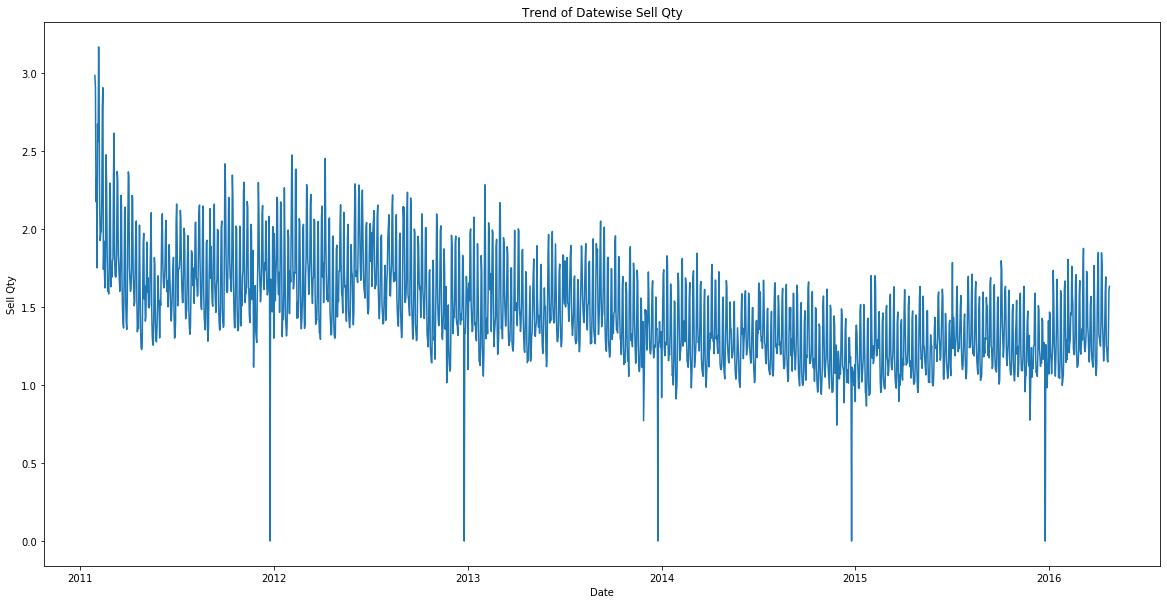

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(total_x["date"], total_x["dValue"])
plt.title('Trend of Datewise Sell Qty')
plt.ylabel('Sell Qty')
plt.xlabel('Date')
plt.show()

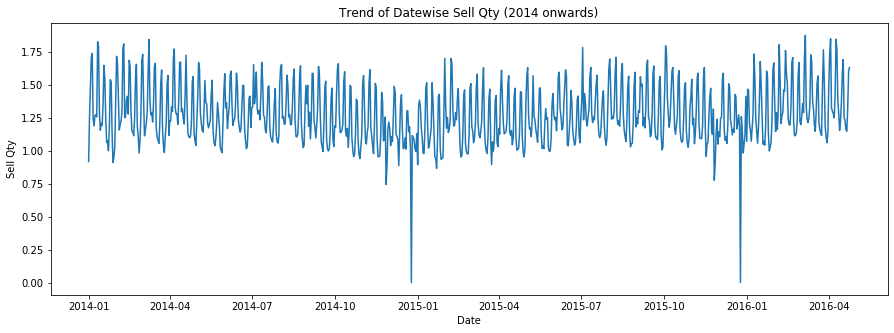

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(total_x[pd.DatetimeIndex(total_x['date']).year >= 2014].iloc[:,0], 
         total_x[pd.DatetimeIndex(total_x['date']).year >= 2014].iloc[:,10])
plt.title('Trend of Datewise Sell Qty (2014 onwards)')
plt.ylabel('Sell Qty')
plt.xlabel('Date')
plt.show()

In [12]:
#test set
total_x_lag = copy.deepcopy(total_x[["date", "d", "sell_price", 'event_name_1', 'event_type_1', 
                                     'event_name_2', 'event_type_2','year', 'wday', 'month']])
total_x_lag = total_x_lag[total_x_lag['date'] > '2016-03-27']
total_d_x = copy.deepcopy(total_x_lag[['d']])
total_x_lag = total_x_lag.drop(columns = ['d', 'date'], axis = 1)
total_x_lag = scaler.fit_transform(total_x_lag)

# total_x_test = copy.deepcopy(total_x[["d", "sell_price"]])
total_x_test = pd.DataFrame(copy.deepcopy(total_d_x))
total_x_test["sell_price"] = copy.deepcopy(total_x_lag[:,0])
total_x_test["event_name_1"] = copy.deepcopy(total_x_lag[:,1])
total_x_test["event_type_1"] = copy.deepcopy(total_x_lag[:,2])
total_x_test["event_name_2"] = copy.deepcopy(total_x_lag[:,3])
total_x_test["event_type_2"] = copy.deepcopy(total_x_lag[:,4])
total_x_test["year"] = copy.deepcopy(total_x_lag[:,5])
total_x_test["wday"] = copy.deepcopy(total_x_lag[:,6])
total_x_test["month"] = copy.deepcopy(total_x_lag[:,7])

del total_x_lag
gc.collect()

5037

In [13]:
total_x_test

,d,sell_price,event_name_1,event_type_1,event_name_2,event_type_2,year,wday,month
1885,1886,-1.428441,0.0,0.0,0.0,0.0,0.0,-0.5,-2.449490
1886,1887,-1.428441,0.0,0.0,0.0,0.0,0.0,0.0,-2.449490
1887,1888,-1.428441,0.0,0.0,0.0,0.0,0.0,0.5,-2.449490
1888,1889,-1.428441,0.0,0.0,0.0,0.0,0.0,1.0,-2.449490
1889,1890,-1.428441,0.0,0.0,0.0,0.0,0.0,1.5,0.408248
1890,1891,0.689264,0.0,0.0,0.0,0.0,0.0,-1.5,0.408248
1891,1892,0.689264,0.0,0.0,0.0,0.0,0.0,-1.0,0.408248
1892,1893,0.689264,0.0,0.0,0.0,0.0,0.0,-0.5,0.408248
1893,1894,0.689264,0.0,0.0,0.0,0.0,0.0,0.0,0.408248
1894,1895,0.689264,0.0,0.0,0.0,0.0,0.0,0.5,0.408248


In [14]:
total_x_lag = copy.deepcopy(total_x[['date', 'dValue']])
total_x_lag['date'] = pd.DatetimeIndex(total_x_lag['date']) - pd.DateOffset(28)

total_x = pd.merge(total_x, total_x_lag, how = 'inner', on = 'date')

total_x = total_x.groupby(['date', 'd'], as_index=False, observed=True).mean()

del total_x_lag
gc.collect()

total_x

,date,d,sell_price,event_name_1,event_type_1,event_name_2,event_type_2,year,wday,month,dValue_x,dValue_y
0,2011-01-29,1,-0.098965,19.0,2.0,3.0,1.0,-1.735328,1.0,1.0,2.984907,2.294790
1,2011-01-30,2,-0.098965,19.0,2.0,3.0,1.0,-1.735328,2.0,1.0,2.904226,2.202639
2,2011-01-31,3,-0.098965,19.0,2.0,3.0,1.0,-1.735328,3.0,1.0,2.175540,1.629709
3,2011-02-01,4,-0.098965,19.0,2.0,3.0,1.0,-1.735328,4.0,2.0,2.324552,1.754930
4,2011-02-02,5,-0.098965,19.0,2.0,3.0,1.0,-1.735328,5.0,2.0,1.751372,1.691552
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,2016-03-23,1881,0.021393,19.0,2.0,3.0,1.0,1.664101,5.0,3.0,1.140899,1.159167
1881,2016-03-24,1882,0.021393,24.0,3.0,3.0,1.0,1.664101,6.0,3.0,1.115218,1.149000
1882,2016-03-25,1883,0.021393,19.0,2.0,3.0,1.0,1.664101,7.0,3.0,1.495933,1.328862
1883,2016-03-26,1884,0.021313,19.0,2.0,3.0,1.0,1.664101,1.0,3.0,1.766579,1.605838


In [15]:
#train set
total_x = total_x.drop(columns = ['date', 'dValue_x'], axis = 1)

# total_d_x = copy.deepcopy(total_x[['d']])
# total_x = total_x.drop(columns = ['d'], axis = 1)
# total_x_scale = scaler.fit_transform(total_x)

# total_x['sell_price'] = total_x_scale[:, 0]
# total_x['dValue_y'] = total_x_scale[:, 1]
# total_x['d'] = total_d_x['d']

total_x_train = copy.deepcopy(total_x[["d", "sell_price", "event_name_1", "event_type_1", "event_name_2", "event_type_2",
                                      "year", "wday", "month"]])
total_y_train = copy.deepcopy(total_x['dValue_y'])

del total_d_x
gc.collect()
# del total_x_scale
# gc.collect()
del total_x
gc.collect()

total_x_train = np.array(total_x_train)
total_x_train = total_x_train.reshape(total_x_train.shape[0], total_x_train.shape[1], 1)

total_y_train = np.array(total_y_train)
total_y_train = total_y_train.reshape(total_y_train.shape[0], 1)

print(total_y_train.shape)
total_x_train.shape

(1885, 1)


(1885, 9, 1)

In [16]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units = 100, return_sequences = True, input_shape = (total_x_train.shape[1], total_x_train.shape[2])))
# No. of time steps = 1912, No. of features = total_x_train.shape[1]
regressorGRU.add(Dropout(0.3))

# Second GRU layer
regressorGRU.add(GRU(units = 100, return_sequences = True))
regressorGRU.add(Dropout(0.3))

# Third GRU layer
regressorGRU.add(GRU(units = 100, return_sequences = True))
regressorGRU.add(Dropout(0.3))

# Fourth GRU layer
regressorGRU.add(GRU(units = 100))
regressorGRU.add(Dropout(0.3))

# regressorGRU.add(Flatten())

# The output layer
regressorGRU.add(Dense(units = 1))

# Compiling the RNN
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressorGRU.summary()

# Fitting to the training set
regressorGRU.fit(total_x_train, total_y_train, epochs = 50, batch_size = 32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 9, 100)            30600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 9, 100)            60300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 9, 100)            60300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 100)              

# Train set results

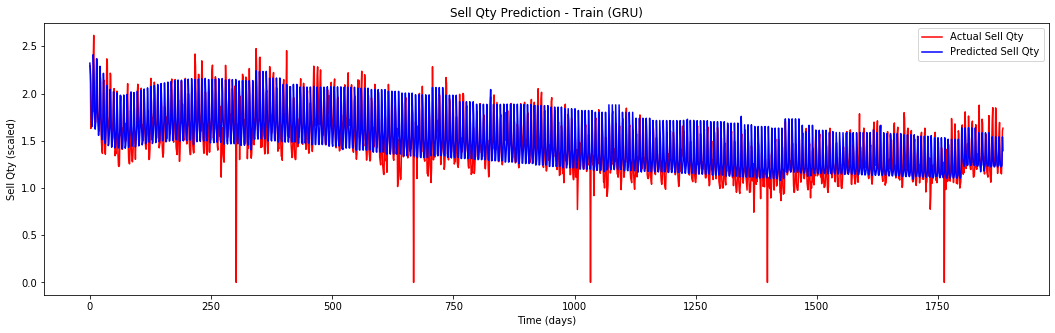

In [17]:
# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_train_sell_qty = regressorGRU.predict(total_x_train)
total_x_train_plot = copy.deepcopy(total_x_train)
total_x_train_plot = total_x_train_plot.reshape(total_x_train_plot.shape[0], total_x_train_plot.shape[1])
# predicted_stock_price = scaler.inverse_transform(predicted_sell_qty)

# Visualizing the results
plt.figure(figsize = (18,5))
plt.plot(total_y_train[:], color = 'red', label = 'Actual Sell Qty')
plt.plot(predicted_train_sell_qty[:], color = 'blue', label = 'Predicted Sell Qty')
plt.title('Sell Qty Prediction - Train (GRU)')
plt.xlabel('Time (days)')
plt.ylabel('Sell Qty (scaled)')
plt.legend()
plt.show()

In [18]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(total_y_train, predicted_train_sell_qty))
print("The root mean squared error is ", round(rmse, 2))

The root mean squared error is  0.17


# Test set results

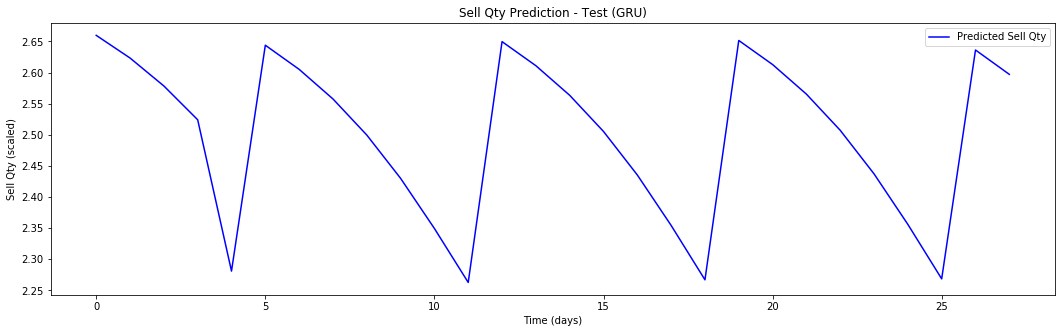

In [19]:
total_x_test = np.array(total_x_test)
total_x_test = total_x_test.reshape(total_x_test.shape[0], total_x_test.shape[1], 1)

predicted_test_sell_qty = regressorGRU.predict(total_x_test)
total_x_train_plot = copy.deepcopy(total_x_train)
total_x_train_plot = total_x_train_plot.reshape(total_x_train_plot.shape[0], total_x_train_plot.shape[1])
# predicted_stock_price = scaler.inverse_transform(predicted_sell_qty)

# Visualizing the results
plt.figure(figsize = (18,5))
plt.plot(predicted_test_sell_qty[:], color = 'blue', label = 'Predicted Sell Qty')
plt.title('Sell Qty Prediction - Test (GRU)')
plt.xlabel('Time (days)')
plt.ylabel('Sell Qty (scaled)')
plt.legend()
plt.show()